# ================================
# EX2: BOW vs LDA on 20 Newsgroups
# ================================

In [ ]:
import nltk.data

# Only set original load once
if not hasattr(nltk.data, "_original_load"):
    nltk.data._original_load = nltk.data.load

# Patch: redirect tagger_eng to working one
def patched_load(resource_url, *args, **kwargs):
    if "averaged_perceptron_tagger_eng" in resource_url:
        print("🔁 Redirecting to: averaged_perceptron_tagger")
        return nltk.data._original_load("taggers/averaged_perceptron_tagger", *args, **kwargs)
    return nltk.data._original_load(resource_url, *args, **kwargs)

nltk.data.load = patched_load


In [ ]:
import nltk

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import re, time, numpy as np
from collections import defaultdict
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# Preprocessing utilities
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(r"\n+", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t.isalnum() and t not in stop_words and len(t) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]  # No POS tagging
    return " ".join(lemmas)

In [ ]:
# Load and preprocess dataset
data = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"))
X_raw, y = data.data, data.target
target_names = data.target_names
X_clean = [preprocess(doc) for doc in X_raw]

# Train/Test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 2A: BOW + TF-IDF
bow_vec = CountVectorizer(max_features=1000)
Xtr_counts = bow_vec.fit_transform(X_train)
tfidf = TfidfTransformer()
Xtr_tfidf = tfidf.fit_transform(Xtr_counts)
Xte_tfidf = tfidf.transform(bow_vec.transform(X_test))

In [ ]:
# 2B: LDA + topic distributions
lda_vec = CountVectorizer(max_features=5000)
Xtr_counts_lda = lda_vec.fit_transform(X_train)
lda = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=42)
t0 = time.time()
lda.fit(Xtr_counts_lda)
t1 = time.time()
Xtr_topics = lda.transform(Xtr_counts_lda)
Xte_topics = lda.transform(lda_vec.transform(X_test))

In [ ]:
# Classification
def eval_model(name, clf, Xtr, ytr, Xte, yte):
    t0 = time.time()
    clf.fit(Xtr, ytr)
    t1 = time.time()
    ypred = clf.predict(Xte)
    acc = accuracy_score(yte, ypred)
    f1m = f1_score(yte, ypred, average="macro")
    cm = confusion_matrix(yte, ypred)
    train_time = t1 - t0
    print(f"\n{name}")
    print(f"Train time: {train_time:.2f}s")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-macro: {f1m:.4f}")
    print("Confusion Matrix:", cm.shape)
    return acc, f1m, train_time

results = {}

In [ ]:
print("=== Representation A: TF-IDF (BOW) ===")
acc, f1m, t = eval_model("LogisticRegression (TF-IDF)", LogisticRegression(max_iter=1000), Xtr_tfidf, y_train, Xte_tfidf, y_test)
results["LR_TFIDF"] = (acc, f1m, t)

=== Representation A: TF-IDF (BOW) ===

LogisticRegression (TF-IDF)
Train time: 3.59s
Accuracy : 0.6061
F1-macro: 0.5989
Confusion Matrix: (20, 20)


In [ ]:
acc, f1m, t = eval_model("MultinomialNB (TF-IDF)", MultinomialNB(), Xtr_tfidf, y_train, Xte_tfidf, y_test)
results["NB_TFIDF"] = (acc, f1m, t)


MultinomialNB (TF-IDF)
Train time: 0.01s
Accuracy : 0.5979
F1-macro: 0.5761
Confusion Matrix: (20, 20)


In [ ]:
print("\n=== Representation B: LDA (10 topics) ===")
print(f"LDA fit time: {t1 - t0:.2f}s")
acc, f1m, t = eval_model("LogisticRegression (LDA)", LogisticRegression(max_iter=1000), Xtr_topics, y_train, Xte_topics, y_test)
results["LR_LDA"] = (acc, f1m, t)


=== Representation B: LDA (10 topics) ===
LDA fit time: 133.77s

LogisticRegression (LDA)
Train time: 1.97s
Accuracy : 0.4122
F1-macro: 0.3693
Confusion Matrix: (20, 20)


In [ ]:
acc, f1m, t = eval_model("MultinomialNB (LDA)", MultinomialNB(), Xtr_topics, y_train, Xte_topics, y_test)
results["NB_LDA"] = (acc, f1m, t)


MultinomialNB (LDA)
Train time: 0.02s
Accuracy : 0.4016
F1-macro: 0.3450
Confusion Matrix: (20, 20)


In [ ]:
# Print table and top LDA words
def print_results_table(res):
    print("\n=== Summary: Accuracy / F1-macro ===")
    for k, (a, f, _) in res.items():
        print(f"{k:15s}  Acc: {a:.4f}  F1m: {f:.4f}")

In [ ]:
def show_top_words(model, feature_names, n_top_words=5):
    print("\n=== LDA Topics: Top words ===")
    for i, topic in enumerate(model.components_):
        top_words = ", ".join([feature_names[j] for j in topic.argsort()[-n_top_words:][::-1]])
        print(f"Topic {i:2d}: {top_words}")

print_results_table(results)
show_top_words(lda, lda_vec.get_feature_names_out(), n_top_words=5)
print("\n Done.")


=== Summary: Accuracy / F1-macro ===
LR_TFIDF         Acc: 0.6061  F1m: 0.5989
NB_TFIDF         Acc: 0.5979  F1m: 0.5761
LR_LDA           Acc: 0.4122  F1m: 0.3693
NB_LDA           Acc: 0.4016  F1m: 0.3450

=== LDA Topics: Top words ===
Topic  0: game, team, player, play, season
Topic  1: use, health, study, medical, disease
Topic  2: max, god, christian, g9v, jesus
Topic  3: car, space, bike, new, system
Topic  4: would, know, please, key, mail
Topic  5: government, gun, law, right, state
Topic  6: drive, card, do, system, window
Topic  7: armenian, people, israel, muslim, state
Topic  8: would, one, think, like, people
Topic  9: file, image, program, window, edu

 Done.


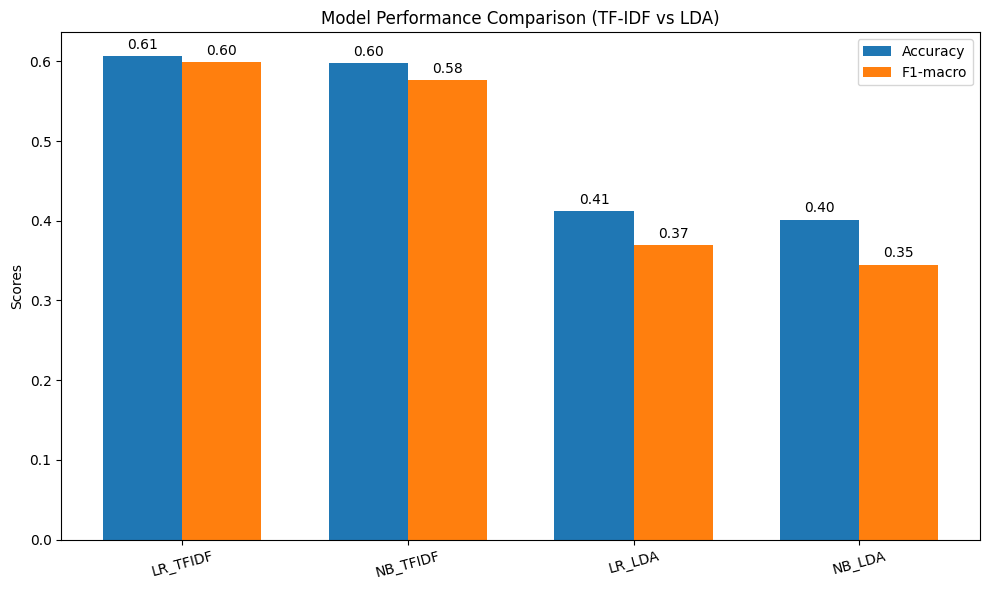

In [ ]:
import matplotlib.pyplot as plt

# Separate out results
labels = list(results.keys())
accs = [results[k][0] for k in labels]
f1s = [results[k][1] for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accs, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1s, width, label='F1-macro')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison (TF-IDF vs LDA)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.legend()

# Attach text labels
def autolabel(rects):
    for r in rects:
        height = r.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(r.get_x() + r.get_width() / 2, height),
                    xytext=(0, 3),  # Offset label
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


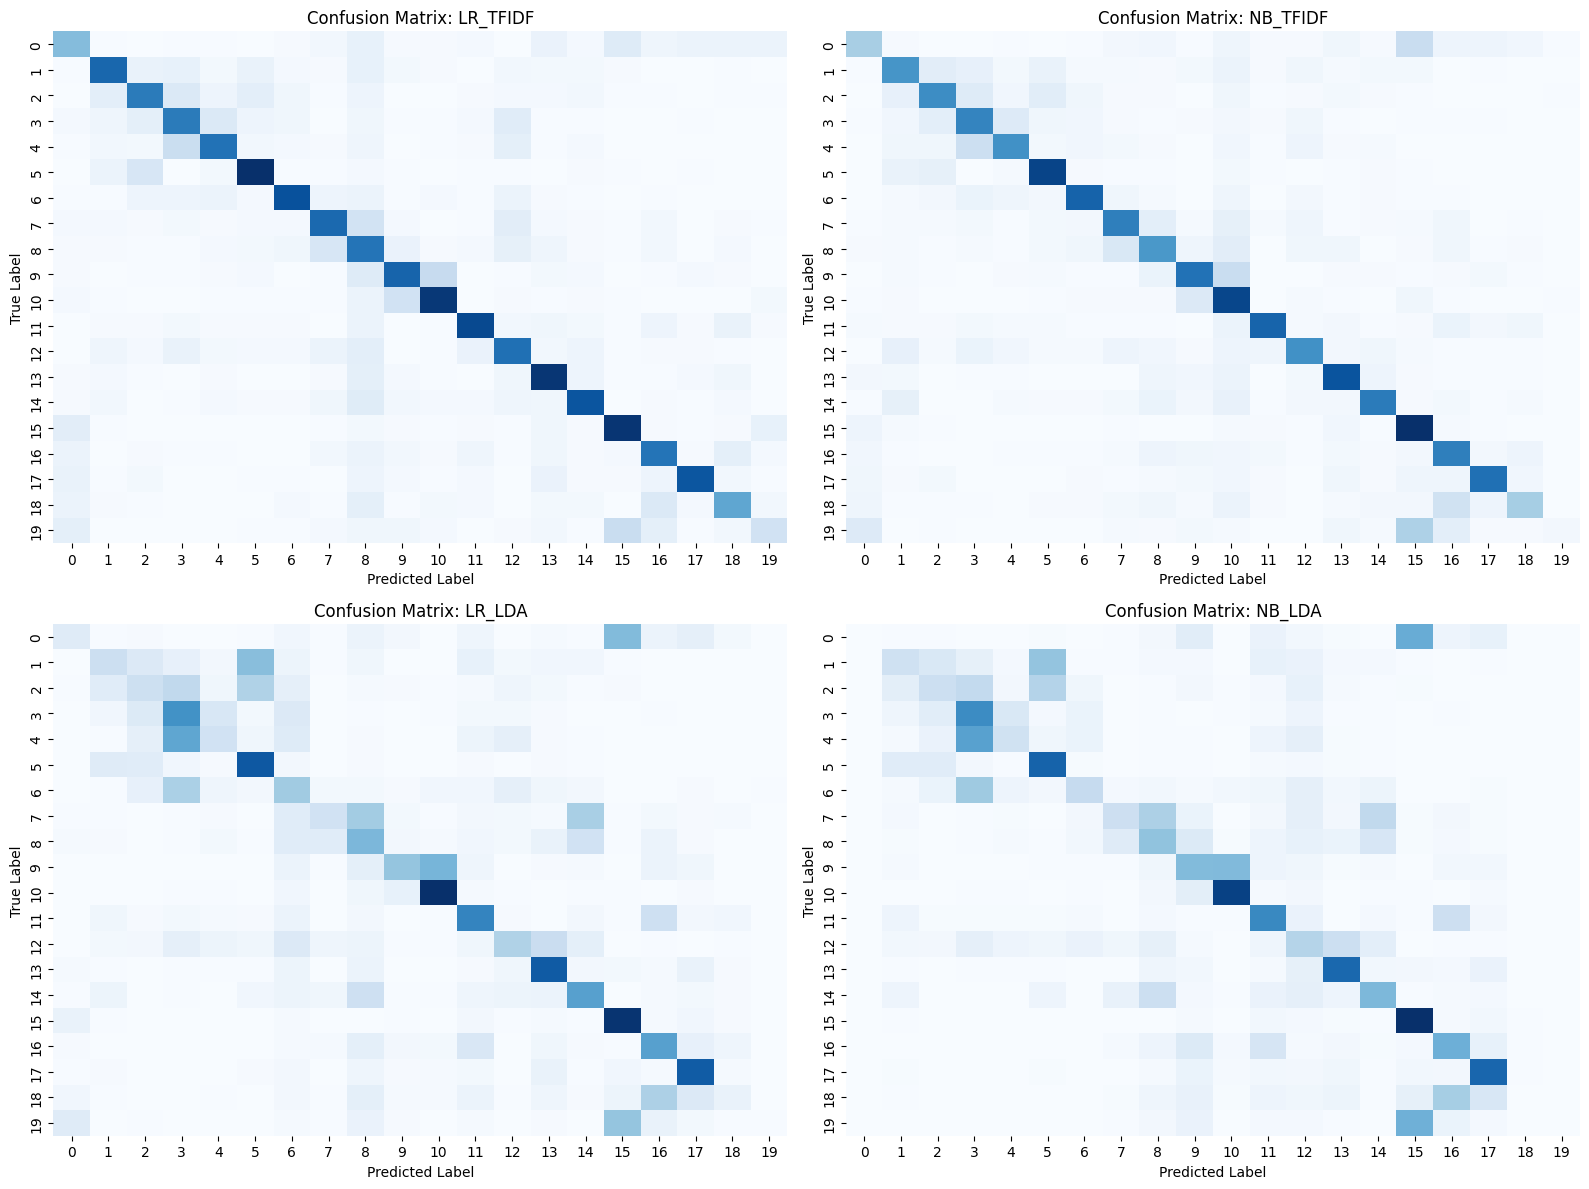

In [ ]:
# ================================
# Confusion Matrix Visualization
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

# Re-train models to get predictions and confusion matrices
conf_matrices = {}

models = {
    "LR_TFIDF": LogisticRegression(max_iter=1000),
    "NB_TFIDF": MultinomialNB(),
    "LR_LDA": LogisticRegression(max_iter=1000),
    "NB_LDA": MultinomialNB()
}

feature_sets = {
    "LR_TFIDF": (Xtr_tfidf, Xte_tfidf),
    "NB_TFIDF": (Xtr_tfidf, Xte_tfidf),
    "LR_LDA": (Xtr_topics, Xte_topics),
    "NB_LDA": (Xtr_topics, Xte_topics)
}

for name, model in models.items():
    Xtr, Xte = feature_sets[name]
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, ax=ax, cmap="Blues", cbar=False, fmt='d')
    ax.set_title(f"Confusion Matrix: {name}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()
